In [1]:
import numpy as np
np.random.seed(0)
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomTreesEmbedding,RandomForestClassifier,GradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.feature_selection import SelectKBest, RFE

In [2]:
#skin dataset - 3 features and 1 target
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00229/Skin_NonSkin.txt'
skin_data_raw = pd.read_csv(url,sep='\t',names=['x1','x2','x3','target'])

In [3]:
print(skin_data_raw['target'].unique())
skin_data_raw['target']=skin_data_raw['target'].map({1:0,2:1})
skin_data_raw.head()

[1 2]


,x1,x2,x3,target
0,74,85,123,0
1,73,84,122,0
2,72,83,121,0
3,70,81,119,0
4,70,81,119,0


In [4]:
skin_data_raw['target'].unique()

array([0, 1], dtype=int64)

In [5]:
X = skin_data_raw.values[:,:3]
y = skin_data_raw.values[:,3]

In [6]:
#X_test,y_test used for final model evaluation
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.33,random_state=0)

In [7]:
from tree_feature_transformation import TreeTransformClf
%load_ext autoreload
%autoreload 2

In [8]:
#Estimating a Random Forest + Logit
#Random Forest
param_dict = {'n_estimators':10,
              'max_depth':3}
rf_logit_model = TreeTransformClf(RandomForestClassifier,tree_params=param_dict,random_state=0,logit_C=1)
rf_logit_model.fit(X_train,y_train)
rf_logit_pred = rf_logit_model.predict_proba(X_test)[:, 1]
fpr_rf_lm, tpr_rf_lm, _ = roc_curve(y_test, rf_logit_pred)

In [9]:
#Gradient boosted model by itself
grdb_clf = GradientBoostingClassifier(n_estimators = 10, max_depth=3)
grdb_clf.fit(X_train,y_train)
y_pred_grdb = grdb_clf.predict_proba(X_test)[:, 1]
fpr_grdb, tpr_grdb, _ = roc_curve(y_test, y_pred_grdb)

In [10]:
#Random Forest by itself
rf = RandomForestClassifier(n_estimators=10,max_depth=3)
rf.fit(X_train,y_train)
y_pred_rf = rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)

In [11]:
#Logit regression by itself
#Linear Regression by itself
lm = LogisticRegression()
lm.fit(X_train,y_train)
y_pred_lm = lm.predict_proba(X_test)[:, 1]
fpr_lm, tpr_lm, _ = roc_curve(y_test, y_pred_lm)

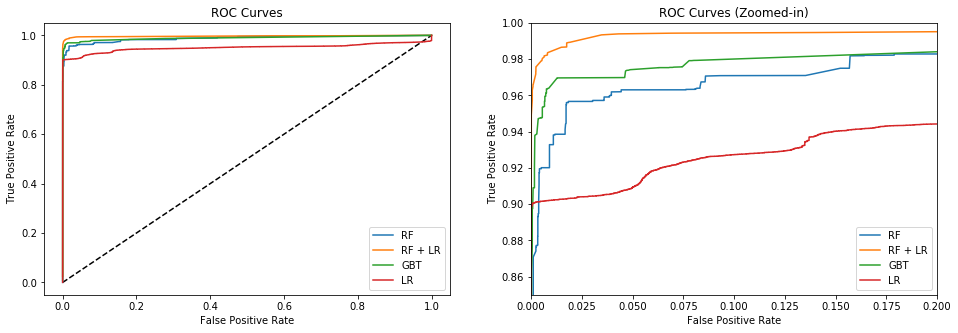

In [12]:
plt.figure(figsize=(16,5))

plt.subplot(1,2,1)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_rf_lm, tpr_rf_lm, label='RF + LR')
plt.plot(fpr_grdb, tpr_grdb, label='GBT')
plt.plot(fpr_lm,tpr_lm,label='LR')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.xlim(0, 0.2)
plt.ylim(0.85, 1)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_rf_lm, tpr_rf_lm, label='RF + LR')
plt.plot(fpr_grdb, tpr_grdb, label='GBT')
plt.plot(fpr_lm,tpr_lm,label='LR')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (Zoomed-in)')
plt.legend(loc='lower right')

plt.show()